<a href="https://colab.research.google.com/github/hector-sm/Weather-Forecast/blob/master/TimeSeriesForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [1]:
import os
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Weather dataset**

In this routine we will use a [weather time series dataset](https://smn.conagua.gob.mx/es/observando-el-tiempo/estaciones-meteorologicas-automaticas-ema-s) recorded by the [Sistema Meteorologico Nacional](https://smn.conagua.gob.mx/) in Mexico.

This dataset contains 9 features such as air temperature, atmospheric pressure, and humidity. This were collected every 10 minutes, for the past 90 days. 

In [ ]:
# # Download dataset

# url = 'https://github.com/hector-sm/Weather-Forecast/blob/master/Data/Estacion_ESCNALCIENCIASBIOLOGICAS__90_dias.csv'
# os.mkdir(f'{os.getcwd()}/Data')
# path_to_file = tf.keras.utils.get_file(f'{os.getcwd()}/Data/Estacion_ESCNALCIENCIASBIOLOGICAS__90_dias.csv', url)

# df = pd.read_csv(path_to_file)

# date_time = pd.to_datetime(df.pop)

In [41]:
# Retrieve dataset from Google Drive

file_dir = f'{os.getcwd()}/drive/My Drive/Colab Notebooks/Data/AR-VI-REAGAN NATIONAL AIRPORT.csv'
df = pd.read_csv(file_dir)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (30,31,33,34,41,42,43,46,48,49,51,52,53,69,71,73,75,76,88,89) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [42]:
# Set maximum length of rows and columns for the DataFrame display
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Make a list of all the features in the original dataset
df.columns.to_list()

# List of the features of interest for our analysis
columns_of_interest = ['DATE', 'HourlyAltimeterSetting', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature',
                       'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 'HourlyStationPressure',
                       'HourlyVisibility', 'HourlyWindDirection', 'HourlyWindSpeed']

# Contruct a filtered dataset with only the relevant features
filtered_df = df[columns_of_interest]
filtered_df.head()

# Pick only the hourly observations
filtered_df = filtered_df[filtered_df.DATE.str.contains(":52:")]
filtered_df.head()

# Pop the date column from the filtered dataset and convert it to datetime stamps
date_time = pd.to_datetime(filtered_df.pop('DATE'), format='%Y-%m-%dT%H:%M:%S')

In [43]:
# Convert all string type columns to numeric
filtered_df['HourlyAltimeterSetting'] = pd.to_numeric(filtered_df['HourlyAltimeterSetting'], errors='coerce')
filtered_df['HourlyDewPointTemperature'] = pd.to_numeric(filtered_df['HourlyDewPointTemperature'], errors='coerce')
filtered_df['HourlyDryBulbTemperature'] = pd.to_numeric(filtered_df['HourlyDryBulbTemperature'], errors='coerce')
filtered_df['HourlyRelativeHumidity'] = pd.to_numeric(filtered_df['HourlyRelativeHumidity'], errors='coerce')
filtered_df['HourlySeaLevelPressure'] = pd.to_numeric(filtered_df['HourlySeaLevelPressure'], errors='coerce')
filtered_df['HourlyStationPressure'] = pd.to_numeric(filtered_df['HourlyStationPressure'], errors='coerce')
filtered_df['HourlyVisibility'] = pd.to_numeric(filtered_df['HourlyVisibility'], errors='coerce')
filtered_df['HourlyWindDirection'] = pd.to_numeric(filtered_df['HourlyWindDirection'], errors='coerce')
print(filtered_df.dtypes)

# Check for NaN values in each column
print(filtered_df.isnull().sum())

# Impute all NaN values with the average for each column
filtered_df = filtered_df.fillna(filtered_df.mean())
print(filtered_df.isnull().sum())

HourlyAltimeterSetting       float64
HourlyDewPointTemperature    float64
HourlyDryBulbTemperature     float64
HourlyRelativeHumidity       float64
HourlySeaLevelPressure       float64
HourlyStationPressure        float64
HourlyVisibility             float64
HourlyWindDirection          float64
HourlyWindSpeed              float64
dtype: object
HourlyAltimeterSetting        166
HourlyDewPointTemperature     181
HourlyDryBulbTemperature      156
HourlyRelativeHumidity        153
HourlySeaLevelPressure        203
HourlyStationPressure         323
HourlyVisibility              171
HourlyWindDirection          1942
HourlyWindSpeed               161
dtype: int64
HourlyAltimeterSetting       0
HourlyDewPointTemperature    0
HourlyDryBulbTemperature     0
HourlyRelativeHumidity       0
HourlySeaLevelPressure       0
HourlyStationPressure        0
HourlyVisibility             0
HourlyWindDirection          0
HourlyWindSpeed              0
dtype: int64


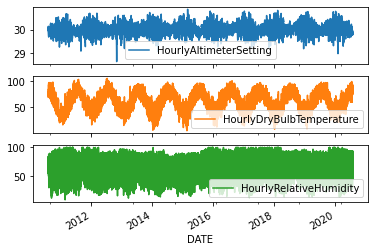

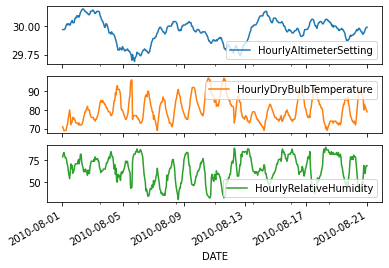

In [44]:
plot_columns = ['HourlyAltimeterSetting', 'HourlyDryBulbTemperature', 'HourlyRelativeHumidity']
plot_features = filtered_df[plot_columns]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

# Zoom in to the first 480 hours
plot_features = filtered_df[plot_columns][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [45]:
# Take a look at the statistics of the dataset:
filtered_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
HourlyAltimeterSetting,87795.0,30.055086,0.217158,28.64,29.92,30.05,30.19,30.88
HourlyDewPointTemperature,87795.0,45.796676,19.059769,-15.00,31.00,48.00,63.00,81.00
HourlyDryBulbTemperature,87795.0,59.704652,17.823191,6.00,45.00,60.00,75.00,105.00
HourlyRelativeHumidity,87795.0,62.909461,18.905887,9.00,48.00,63.00,79.00,100.00
HourlySeaLevelPressure,87795.0,30.052511,0.216926,28.63,29.91,30.05,30.19,30.88
HourlyStationPressure,87795.0,29.985218,0.216914,28.57,29.85,29.98,30.12,30.81
HourlyVisibility,87795.0,9.504899,1.616921,0.00,10.00,10.00,10.00,10.00
HourlyWindDirection,87795.0,183.706685,112.605193,0.00,80.00,190.00,290.00,360.00
HourlyWindSpeed,87795.0,8.370301,5.023405,0.00,5.00,8.00,11.00,44.00


## Feature engineering

The last two columns of the data, HourlyWindDirection, gives the wind direction in units of degrees. Angles do not make good model inputs, 360 and 0 should be close to each other, and wrap around smoothly.

Text(0, 0.5, 'Wind Velocity [m/s]')

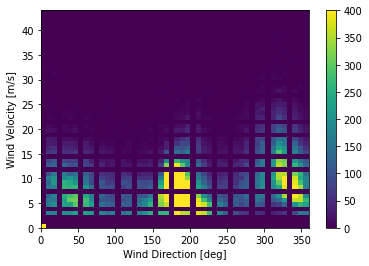

In [46]:
# Feature engineering

plt.hist2d(filtered_df['HourlyWindDirection'], filtered_df['HourlyWindSpeed'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

(-29.544232590366242,
 38.10511776651529,
 -34.76862696907861,
 31.949549106720887)

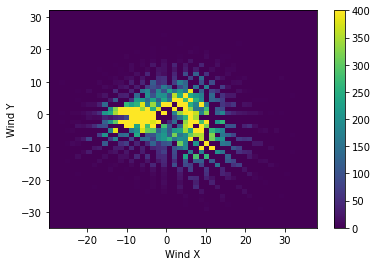

In [47]:
WindSpeed = filtered_df.pop('HourlyWindSpeed')
WindDirRadians = filtered_df.pop('HourlyWindDirection') * (np.pi/180)

# Calculate the wind x and y components.
filtered_df['WindCompX'] = WindSpeed*np.cos(WindDirRadians)
filtered_df['WindCompY'] = WindSpeed*np.sin(WindDirRadians)

plt.hist2d(filtered_df['WindCompX'], filtered_df['WindCompY'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X')
plt.ylabel('Wind Y')
ax = plt.gca()
ax.axis('tight')

In [48]:
# Time
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use sin and cos to convert the time to clear "Time of day" and "Time of year" signals:

Text(0.5, 1.0, 'Time of day signal')

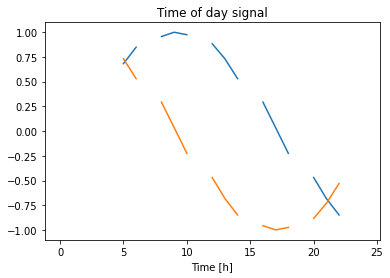

In [50]:
day = 24*60*60
year = (365.2425)*day

filtered_df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
filtered_df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
filtered_df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
filtered_df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')